In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import glob
import pickle
import tensorflow as tf    # used for creating tensors out of the dataset and training the model
import tensorflow_hub as hub    # downloading and using pre-trained models
import numpy as np
import h5py   # to manipulate the dataset as it's in `.h5` format
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report   # essential for model's evaluation
from sklearn.metrics import f1_score
from tqdm import tqdm   # getting a progress bar for an iterable object

In [3]:
!pip install plotly

In [4]:
!pip install tqdm

In [3]:
train_df64= pd.read_csv('C:/Users/vansh/Desktop/Vansh notes/BE project multiclass/dataset/test64.csv')
train_df64.head()

,index,angle,indication_type,indication_value,split
0,0,100,good,0,test
1,1,40,good,0,test
2,2,40,good,0,test
3,3,120,good,0,test
4,4,20,good,0,test


In [4]:
train_df64.indication_type.value_counts()

good                   8000
color                  8000
cut                    8000
hole                   8000
metal_contamination    8000
thread                 8000
Name: indication_type, dtype: int64

In [5]:
# create an object that will take the dataset and produce the dataset in a format required for tensorflow dataset's API
class H5ToStorage:
    def __init__(self, hdf_path, ds_name="train"):
        self.path = hdf_path

        self.classes = []
        with h5py.File(self.path, 'r') as hf:
            for class_ in hf:
                self.classes.append(class_)

        self.name = ds_name

  # a generator to load the (img, class, angle)
    def generate_img_arr(self):
        for class_ in self.classes:
            with h5py.File(self.path, 'r') as hf:
                for angle in hf[class_]:
                    for img in hf[class_][f"{angle}"]:
                        yield img, class_, angle
  
  # utilize the generator to create new images and load it back to Storage
    def generate_train_dirs(self):
    # create the dataset's directories
        path = f"workings/dataset/{self.name}"
        os.makedirs(f"{path}/good/")
        os.makedirs(f"{path}/color/")
        os.makedirs(f"{path}/cut/")
        os.makedirs(f"{path}/hole/")
        os.makedirs(f"{path}/metal_contamination/")
        os.makedirs(f"{path}/thread/")
    

        gen = self.generate_img_arr()
        metadata = {}

        for i, data in enumerate(gen):
            img, label, angle = data
            if label == "good":
                img_path = f"{path}/good/{i}.jpeg"
                plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
            else:
                img_path = f"{path}/{label}/{i}.jpeg"
                plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

            metadata[img_path] = angle
        return metadata

    def generate_test_dirs(self):
    # create the dataset's directories
        path = f"workings/dataset/{self.name}"
        os.makedirs(f"{path}/good/")
        os.makedirs(f"{path}/color/")
        os.makedirs(f"{path}/cut/")
        os.makedirs(f"{path}/hole/")
        os.makedirs(f"{path}/metal_contamination/")
        os.makedirs(f"{path}/thread/")

        gen = self.generate_img_arr()
        metadata = {}

        for i, data in enumerate(gen):
            img, label, angle = data
            if label == "good":
                img_path = f"{path}/good/{i}.jpeg"
                plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
            else:
                img_path = f"{path}/{label}/{i}.jpeg"
                plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

            metadata[img_path] = angle

        return metadata

    def to_storage(self):
        if self.name == "train":
            self.generate_train_dirs()

        elif self.name == "test":
            self.generate_test_dirs()

In [10]:
train_gen= H5ToStorage("C:/Users/vansh/Desktop/Vansh notes/BE project multiclass/dataset/matchingtDATASET_train_64.h5", "train")
train_dict= train_gen.to_storage()

In [11]:
test_gen= H5ToStorage("C:/Users/vansh/Desktop/Vansh notes/BE project multiclass/dataset/matchingtDATASET_test_64.h5", "test")
test_dict= test_gen.to_storage()

In [6]:
test_dir= "C:/Users/vansh/Desktop/Vansh notes/BE project multiclass/workings/dataset/test"
train_dir= "C:/Users/vansh/Desktop/Vansh notes/BE project multiclass/workings/dataset/train"

In [7]:
def one_hot_encode(image, label):
    # One-hot encode the label
    one_hot_label = tf.one_hot(label, depth=num_classes)
    return image, one_hot_label

In [34]:
# create train data pipeline
IMG_SIZE = (64, 64) # define image size
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=IMG_SIZE,
                                                         color_mode="grayscale",
                                                         label_mode="int", #  label type is encoding of the form `[1, 2, 3, ...]`
                                                         batch_size=64) # batch_size is 32 by default, but 128 will be used for this use-case
# classes in train_data
class_names = train_data.class_names
print(f"The class_names are as follows: {class_names}")
num_classes=6

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                        cache()
train_data = train_data.map(one_hot_encode)
print(len(train_data))
# create test data pipeline
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        color_mode="grayscale",
                                                        shuffle=False,
                                                        batch_size=128,
                                                        label_mode="int")

test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                      cache() 

test_data = test_data.map(one_hot_encode)

Found 72000 files belonging to 6 classes.
The class_names are as follows: ['color', 'cut', 'good', 'hole', 'metal_contamination', 'thread']
1125
Found 36000 files belonging to 6 classes.


In [35]:
first_batch =train_data.take(1)
for e in first_batch:
    print(e)
    break

(<tf.Tensor: shape=(64, 64, 64, 1), dtype=float32, numpy=
array([[[[165.],
         [163.],
         [163.],
         ...,
         [ 93.],
         [ 96.],
         [105.]],

        [[166.],
         [163.],
         [160.],
         ...,
         [ 98.],
         [ 94.],
         [ 95.]],

        [[170.],
         [163.],
         [156.],
         ...,
         [105.],
         [ 93.],
         [ 85.]],

        ...,

        [[169.],
         [170.],
         [173.],
         ...,
         [ 47.],
         [ 29.],
         [ 16.]],

        [[159.],
         [164.],
         [175.],
         ...,
         [ 22.],
         [  9.],
         [  3.]],

        [[156.],
         [161.],
         [174.],
         ...,
         [ 15.],
         [  6.],
         [  7.]]],


       [[[ 85.],
         [ 76.],
         [ 64.],
         ...,
         [149.],
         [161.],
         [155.]],

        [[ 76.],
         [ 72.],
         [ 68.],
         ...,
         [173.],
         [158.],
 

In [36]:
# check the proportions of classes
color_counts = 0
for _ in os.listdir(f"{train_dir}/color"):
    color_counts += 1
    
cut_counts = 0
for _ in os.listdir(f"{train_dir}/cut"):
    cut_counts += 1

hole_counts = 0
for _ in os.listdir(f"{train_dir}/hole"):
    hole_counts += 1

    
metal_contamination_counts = 0    
for _ in os.listdir(f"{train_dir}/metal_contamination"):
    metal_contamination_counts += 1

thread_counts = 0
for _ in os.listdir(f"{train_dir}/thread"):
    thread_counts += 1
    
good_counts = 0
for _ in os.listdir(f"{train_dir}/good"):
    good_counts += 1
    
total= color_counts+ cut_counts+ hole_counts+ metal_contamination_counts+ thread_counts+good_counts
new_traindf64= pd.Series({
    "good": good_counts/total,
    "color": color_counts/total,
    "cut": cut_counts/total,
    "hole": hole_counts/total,
    "metal_contamination": metal_contamination_counts/total,
    "thread": thread_counts/total
}).round(2)

new_traindf64

good                   0.17
color                  0.17
cut                    0.17
hole                   0.17
metal_contamination    0.17
thread                 0.17
dtype: float64

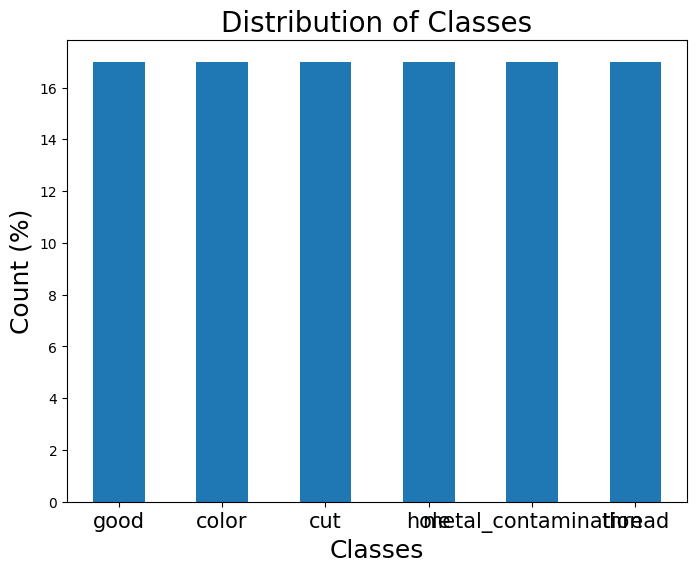

In [37]:
# check the classes distribution
(new_traindf64*100).to_frame().plot.bar(legend=False, figsize=(8, 6))
plt.xlabel('Classes', fontsize=18)
plt.ylabel("Count (%)", fontsize=18)
plt.title("Distribution of Classes", fontsize=20)
plt.xticks(rotation=0, fontsize=15);

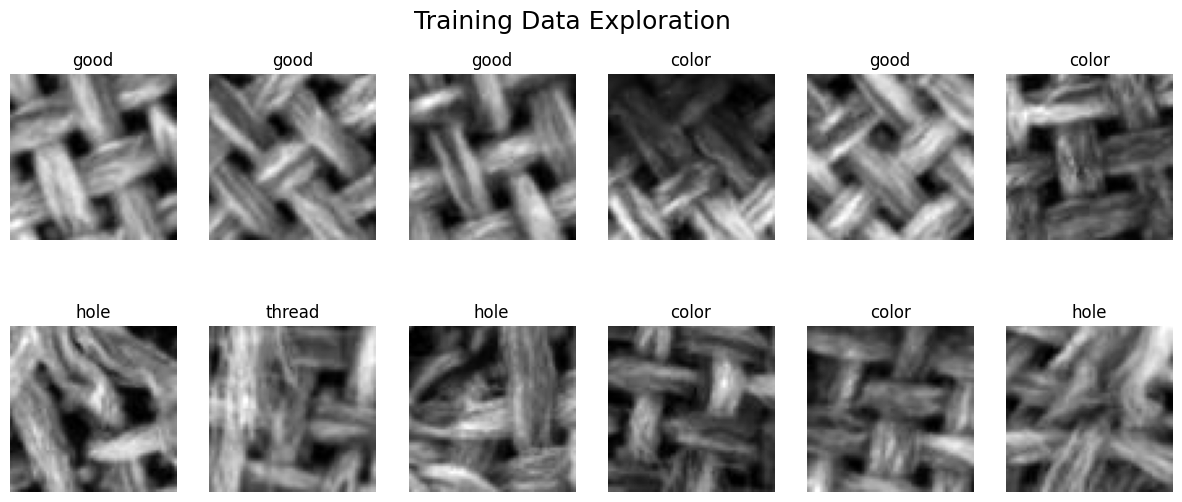

In [38]:
# explore the train data
def explore_data(n_rows, n_cols, figsize):
    count = 0
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize) # plot 20 figures
    fig.suptitle("Training Data Exploration", fontsize=18, y=0.95)
    for data, ax in zip(train_data.shuffle(10000).take(1).unbatch(), axs.ravel()):
        img, label = data

        ax.axis("off")
        ax.set_title(f"{class_names[tf.where(label==1)[0][0].numpy()]}")
        ax.imshow(np.squeeze(img), cmap="gray")

        count+=1
        if count == n_rows*n_cols:
            break

explore_data(n_rows=2, n_cols=6, figsize=(15, 6))

In [39]:
# create a baseline model to get the baseline metric
num_classes=6
baseline_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(64, 64, 1), name="input_layer"),
        tf.keras.layers.Conv2D(3, 1, padding="valid", activation="relu"),
        tf.keras.layers.Conv2D(16, 2, activation="relu"),
        tf.keras.layers.Conv2D(32, 2, activation="relu"),
        tf.keras.layers.Conv2D(64, 3, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 4, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(512, 4, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
    ]
)

# get model summary
baseline_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 3)         6         
                                                                 
 conv2d_13 (Conv2D)          (None, 63, 63, 16)        208       
                                                                 
 conv2d_14 (Conv2D)          (None, 62, 62, 32)        2080      
                                                                 
 conv2d_15 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 27, 27, 128)       131200    
                                                      

In [40]:
# define callbacks
# Setup ReduceLROnPlateau callback to reduce learning rate if model's val_loss doesn't improve for 1 epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3, # if val_accuracy decreases for 3 epochs in a row, stop training
                                                  restore_best_weights=True,
                                                  verbose=1)

In [41]:
# compile the `baseline_model`
baseline_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

In [42]:
print(len(train_data))

1125


In [49]:
# train the `baseline_model`
EPOCHS = 10
# STEPS_PER_EPOCH = len(train_data)
STEPS_PER_EPOCH=1
baseline_training_history = baseline_model.fit(train_data,
                                               epochs=EPOCHS,
                                               steps_per_epoch=STEPS_PER_EPOCH,
                                               validation_data=test_data.shuffle(10000),
                                               validation_steps=int(0.5 * len(test_data)),
                                               callbacks=[reduce_lr, early_stopping]
                                               )

Epoch 1/10


1/1 [==============================] - 90s 90s/step - loss: 2.9565 - accuracy: 0.3125 - val_loss: 2.9380 - val_accuracy: 0.1551 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 92s 92s/step - loss: 2.8905 - accuracy: 0.1406 - val_loss: 2.8396 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 3/10

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1/1 [==============================] - 94s 94s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 2.8439 - val_accuracy: 0.1524 - lr: 0.0010


In [46]:
# baseline_model's loss and accuracy
baseline_model.evaluate(test_data)

563/563 [==============================] - 180s 320ms/step - loss: 1.3731 - accuracy: 0.5353


[1.3730777502059937, 0.5353333353996277]

In [15]:
baseline_model.save("C:/Users/vansh\Desktop/Vansh notes/BE project multiclass/workings/baseline_model.h5")

NameError: name 'baseline_model' is not defined

In [16]:
baseline_model='C:/Users/vansh/Desktop/Vansh notes/BE project multiclass/workings/baseline_model.h5'

In [17]:
# function to get the model's ground truth and predicted labels
def get_labels(dataset, model):
    y_labels = []
    for _, label in tqdm(dataset.unbatch()):
        y_labels.append(tf.where(label==1)[0][0].numpy())

    y_preds = model.predict(dataset, verbose=1)
    y_preds_final=[]
    for pred in y_preds:
        y_preds_final.append(np.argmax(pred))
    return y_labels, y_preds_final

In [18]:
# get the labels for baseline model
y_labels, y_preds = get_labels(test_data, baseline_model)

0it [00:00, ?it/s]

36000it [01:26, 414.76it/s]


AttributeError: 'str' object has no attribute 'predict'

In [52]:
y_preds[0],y_labels[0]

(0, 0)

In [53]:
# check the labels
y_labels[:20], np.round(y_preds[:20])

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 array([0, 1, 3, 0, 0, 5, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 5],
       dtype=int64))

In [54]:
# get the classification report
print("############### Classification Report ###############\n\n")
print(classification_report(y_labels, np.round(y_preds)))

############### Classification Report ###############


              precision    recall  f1-score   support

           0       0.70      0.57      0.63      6000
           1       0.37      0.35      0.36      6000
           2       0.60      0.77      0.67      6000
           3       0.31      0.38      0.34      6000
           4       0.82      0.79      0.81      6000
           5       0.46      0.35      0.40      6000

    accuracy                           0.54     36000
   macro avg       0.54      0.54      0.53     36000
weighted avg       0.54      0.54      0.53     36000

